In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from celluloid import Camera

In [3]:
def f_adjacent(x, p):
    x_right = np.roll(x,1)
    x_left = np.roll(x,-1)

    # ...left: force on i from (i+1)

    x_diff_right = x['x'] - x_right['x'] 
    y_diff_right = x['y'] - x_right['y']
    x_diff_left = x['x'] - x_left['x']
    y_diff_left = x['y'] -x_left['y']

    distances_right = (x_diff_right**2 + y_diff_right**2)**(1/2)
    distances_left = (x_diff_left**2 + y_diff_left**2)**(1/2)

    fx_left = -1 * k * x_diff_left * (1 - l/distances_left) # * stretching
    fy_left = -1 * k * y_diff_left  * (1 - l/distances_left) # * stretching
    fx_right = -1 * k * x_diff_right * (1 - l/distances_right) # * stretching
    fy_right = -1 * k * y_diff_right * (1 - l/distances_right) # * stretching

    if periodic == False:
        fx_left[-1] = 0
        fy_left[-1] = 0
        fx_right[0] = 0
        fy_right[0] = 0

    fx = fx_left + fx_right
    fy = fy_left + fy_right
    if topFixed == True:
        fx[0] = 0
        fy[0] = 0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])
    

def f_twoadjacent(x, p):
    # forces between every other element
    x_diff2_right = x['x'] - np.roll(x,2)['x'] 
    y_diff2_right = x['y'] - np.roll(x,2)['y']
    x_diff2_left = x['x'] - np.roll(x,-2)['x']
    y_diff2_left = x['y'] - np.roll(x,-2)['y']

    fx2_left = -1 * k2 * x_diff_left * (1 - 2*l/(x_diff2_left**2 + y_diff2_left**2)**(1/2)) # * stretching
    fy2_left = -1 * k2 * y_diff_left  * (1 - 2*l/(x_diff2_left**2 + y_diff2_left**2)**(1/2)) # * stretching
    fx2_right = -1 * k2 * x_diff_right * (1 - 2*l/(x_diff2_right**2 + y_diff2_right**2)**(1/2)) # * stretching
    fy2_right = -1 * k2 * y_diff_right * (1 - 2*l/(x_diff2_right**2 + y_diff2_right**2)**(1/2)) # * stretching

    if periodic == False:
        fx2_left[-1] = 0
        fy2_left[-1] = 0
        fx2_left[-2] = 0
        fy2_left[-2] = 0
        fx2_right[0] = 0
        fy2_right[0] = 0
        fx2_right[1] = 0
        fy2_right[1] = 0

    fx = fx2_left + fx2_right
    fy = fy2_left + fy2_right
    if topFixed == True:
        fx[0] = 0
        fy[0] = 0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

def f_gravity(x, p):
    fx = np.zeros_like(x['x'])
    fy = -1 * m * g
    if topFixed == True:
        fx[0] = 0
        fy[0] = 0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])


def f_air(x, p):
    vx = p['x']/m
    vy = p['y']/m
    fx = -1 * b * vx
    fy = -1 * b * vy
    if topFixed == True:
        fx[0] = 0
        fy[0] = 0
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

def force(x, p):
    fadj_ = f_adjacent(x, p)
    fair_ = f_air(x, p)
    fgrav_ = f_gravity(x, p)
    fx = fadj_['x'] + fair_['x'] + fgrav_['x']
    fy = fadj_['y'] + fair_['y'] + fgrav_['y']
    return np.array(list(zip(fx, fy)), dtype=[('x', np.float32), ('y', np.float32)])

In [4]:
def symplectic_euler(x, p, m, dt):
    # f = np.zeros_like(x)
    # f['x'] = f_adjacent(x, p)['x'] + f_gravity(x, p)['x'] + f_air(x, p)['x']
    # f['y'] = f_adjacent(x, p)['y'] + f_gravity(x, p)['y'] + f_air(x, p)['y']
    f = force(x, p)
    pnext = np.zeros_like(p)
    pnext['x'] = p['x'] + f['x'] * dt
    pnext['y'] = p['y'] + f['y'] * dt
    xnext = np.zeros_like(x)
    xnext['x'] = x['x'] + pnext['x']/m * dt
    xnext['y'] = x['y'] + pnext['y']/m * dt
    return xnext, pnext

def yoshida(x, p, m, dt):

    # parameters for yoshida
    omega_0 = -1 * 2**(1/3) / (2 - 2 ** (1/3))
    omega_1 = 1 / (2 - 2 ** (1/3))
    c1 = omega_1/2
    c4 = omega_1/2
    c2 = (omega_0 + omega_1)/2
    c3 = (omega_0 + omega_1)/2
    d1 = omega_1
    d3 = omega_1
    d2 = omega_0

    x1 = np.zeros_like(x)
    p1 = np.zeros_like(p)
    x1['x'] = x['x'] + c1 * p['x']/m * dt
    x1['y'] = x['y'] + c1 * p['y']/m * dt
    a1 = force(x1, p)
    p1['x'] = p['x'] + m * d1 * a1['x'] * dt
    p1['y'] = p['y'] + m * d1 * a1['y'] * dt

    x2 = np.zeros_like(x)
    p2 = np.zeros_like(p)
    x2['x'] = x1['x'] + c2 * p1['x']/m * dt
    x2['y'] = x1['y'] + c2 * p1['y']/m * dt
    a2 = force(x2, p1)
    p2['x'] = p1['x'] + m * d2 * a2['x'] * dt
    p2['y'] = p1['y'] + m * d2 * a2['y'] * dt
    
    x3 = np.zeros_like(x)
    p3 = np.zeros_like(p)
    x3['x'] = x2['x'] + c3 * p2['x']/m * dt
    x3['y'] = x2['y'] + c3 * p2['y']/m * dt
    a3 = force(x3, p2)
    p3['x'] = p2['x'] + m * d3 * a3['x'] * dt
    p3['y'] = p2['y'] + m * d3 * a3['y'] * dt

    xnext = np.zeros_like(x)
    pnext = np.zeros_like(p)
    xnext['x'] = x3['x'] + c4 * p3['x']/m * dt
    xnext['y'] = x3['y'] + c4 * p3['y']/m * dt
    pnext['x'] = p3['x']
    pnext['y'] = p3['y']
    return xnext, pnext

In [8]:
def animate_structured_array(your_array, filename):
    # Prepare the plot
    fig, ax = plt.subplots()

    line, = ax.plot([], [], 'ro-')  # Red circles with lines connecting them
    ax.set_aspect('equal')  # Set the aspect of the plot to be equal

    # Determine the limits for x and y axes
    x_min = min(subarray['x'].min() for subarray in your_array) - 1
    x_max = max(subarray['x'].max() for subarray in your_array) + 1
    y_min = min(subarray['y'].min() for subarray in your_array) - 1
    y_max = max(subarray['y'].max() for subarray in your_array) + 1
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # Animation function: this is called sequentially
    def animate(i):
        x, y = your_array[i]['x'], your_array[i]['y']
        line.set_data(x, y)
        return line,

    # Call the animator
    anim = FuncAnimation(fig, animate, init_func=init, frames=len(your_array), interval=1, blit=True)

    anim.save(filename, writer='Pillow', fps=24)

    plt.show()

In [67]:
# flags for adding mass and air resistance
addMass = False
addResistance = False
topFixed = True
periodic = False

M = 100 # mass of block
B = 30 # air resistance of parachute

# initialize parameters
N = 21
x_init = np.array([(0, 0) for i in range(N)], dtype=[('x', np.float32), ('y', np.float32)])

# value of m_point and b_point depends on the cases
# standard
b_point = 5
m_point = 5

# mass at bottom
# m_point = 5
# b_point = 20

# parachute
# m_point = 5
# b_point = 3

b = np.ones_like(x_init['x']) * b_point
g = 9.8
m = np.ones_like(x_init['x']) * m_point
v = 8
p_init = np.array([(m_point * v, 0) for i in range(N)], dtype=[('x', np.float32), ('y', np.float32)])
if addMass == True:
    p_init[-1] = (v * M, 0)
    m[-1] = M
k = 5000
l = 0.5
k2 = 100
if addResistance == True:
    b[-1] = B
x_init['y'] = -1 * np.linspace(0, l*(N-1), N)
# p_init['y'] = -1 * np.linspace(0, 10, 21) # if we want to start with initial circular motion

x_all = [x_init]
p_all = [p_init]

# evolve array with time
t_f = 3
dt = 0.01

t = 0
x = x_init
p = p_init
while t < t_f:
    xnext, pnext = yoshida(x, p, m, dt)
    x = xnext
    p = pnext
    x_all.append(x)
    p_all.append(p)
    t += dt

MovieWriter Pillow unavailable; using Pillow instead.


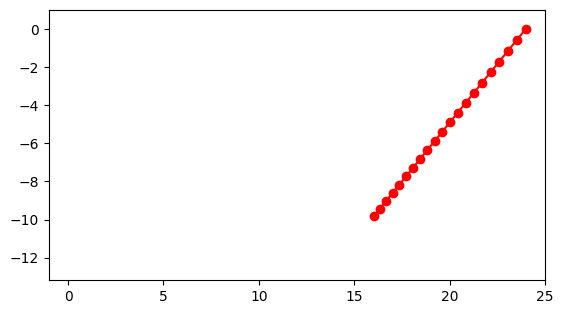

In [65]:
# animate
x_to_animate = x_all[::10]
if periodic == True:
    x_to_animate = [np.concatenate((x_to_animate[i],[x_to_animate[i][0]]),axis=0) for i in range(len(x_to_animate))]

animate_structured_array(x_to_animate, filename = 'standard.gif')